In [4]:
import shutil

import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import warnings
import os

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-09-28 20:02:58.661964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 20:02:59.297020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [5]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [6]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

## Preprocessing


In [7]:
zero_values_percentage_cutoff = 0.2 # no more than x% of data can be zeros
smoothing_window_size = 5
df = preprocess(zero_values_percentage_cutoff=zero_values_percentage_cutoff, smoothing_window_size=smoothing_window_size)

2023-09-28 20:03:07.960303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 20:03:07.977463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 20:03:08.045098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 20:03:08.063450: I tensorflow/core/platform/cpu_featu

In [8]:
df

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,351231,360015,3426658,312140,484304,301578,577170,193233,196664,583117
E000823.1.8,0.002227,0.041986,0.129146,0.077865,0.518151,0.035201,0.211055,0.000621,0.020290,0.153846,...,0.312585,0.000000,0.188791,0.116000,1.000000,0.203540,0.130356,0.042448,0.063005,0.010525
E000823.2.6,0.133886,0.096935,0.148374,0.126036,0.436229,0.034483,0.266332,0.036431,0.028156,0.166667,...,0.272149,0.000139,0.227139,0.128000,0.979496,0.234513,0.125109,0.037373,0.056729,0.010298
E000823.4.0,0.133507,0.097747,0.110079,0.126036,0.374388,0.040230,0.160804,0.036431,0.050804,0.105769,...,0.252158,0.002275,0.174041,0.066000,0.748403,0.146018,0.123361,0.053983,0.069040,0.032819
E000823.5.0,0.134550,0.188216,0.076106,0.105213,0.284225,0.031609,0.125628,0.055682,0.049931,0.073718,...,0.204907,0.002303,0.141593,0.056000,0.567227,0.123894,0.091737,0.048139,0.052505,0.030623
E000823.5.7,0.156825,0.188186,0.065522,0.107413,0.245233,0.050287,0.105528,0.060236,0.053848,0.076923,...,0.199455,0.003580,0.141593,0.062000,0.488039,0.119469,0.069513,0.044909,0.054919,0.083269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.013175,0.001444,0.010099,0.040839,0.188597,0.320402,0.417085,0.072656,0.000025,0.288462,...,0.024989,0.001859,0.383481,0.172000,0.000224,0.314159,0.256339,0.085205,0.131201,0.328075
E014086.23.4,0.041137,0.004301,0.011553,0.040692,0.218657,0.410920,0.492462,0.085490,0.000424,0.375000,...,0.032712,0.003940,0.522124,0.200000,0.000252,0.415929,0.315870,0.110889,0.174412,0.407474
E014086.24.5,0.074028,0.005143,0.012927,0.042452,0.317956,0.614943,0.628141,0.108052,0.001665,0.522436,...,0.053612,0.003247,0.613569,0.484000,0.000252,0.513274,0.378024,0.133959,0.297284,0.596487
E014086.26.4,0.084787,0.004782,0.010341,0.027495,0.370480,0.760057,0.633166,0.113848,0.001778,0.592949,...,0.054521,0.002997,0.575221,0.640000,0.000224,0.526549,0.484407,0.196555,0.417139,0.741297


## Features and targets

In [9]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = cut_to_sequences(feats_df=df, seq_length=seq_length)

y_targets = pd.DataFrame(y_targets)
y_targets.columns = df.columns

X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 516
Total sequences: 466
Train sequences: 411
Test sequences: 55


In [10]:
y_targets

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,351231,360015,3426658,312140,484304,301578,577170,193233,196664,583117
0,0.004834,0.008481,0.000606,0.011584,0.218075,0.043822,0.341709,0.008694,0.032104,0.179487,...,0.222626,0.000166,0.203540,0.130000,0.677703,0.318584,0.051734,0.037066,0.036934,0.062740
1,0.011611,0.013865,0.000040,0.000000,0.230199,0.043822,0.321608,0.000000,0.034718,0.179487,...,0.227624,0.000055,0.241888,0.154000,0.743361,0.314159,0.069659,0.031221,0.035607,0.089471
2,0.021801,0.015940,0.000040,0.000000,0.213074,0.050287,0.341709,0.000000,0.025717,0.233974,...,0.190368,0.136166,0.312684,0.164000,0.416331,0.353982,0.088531,0.025377,0.028485,0.087275
3,0.022844,0.015880,0.000000,0.148838,0.143386,0.046695,0.296482,0.000000,0.017646,0.211538,...,0.130850,0.136110,0.303835,0.138000,0.274706,0.261062,0.065214,0.014611,0.018829,0.067131
4,0.027678,0.018737,0.001899,0.164968,0.219490,0.039511,0.256281,0.028980,0.012718,0.205128,...,0.150841,0.199739,0.286136,0.122000,0.197143,0.194690,0.060187,0.016764,0.025106,0.049771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0.013175,0.001444,0.010099,0.040839,0.188597,0.320402,0.417085,0.072656,0.000025,0.288462,...,0.024989,0.001859,0.383481,0.172000,0.000224,0.314159,0.256339,0.085205,0.131201,0.328075
462,0.041137,0.004301,0.011553,0.040692,0.218657,0.410920,0.492462,0.085490,0.000424,0.375000,...,0.032712,0.003940,0.522124,0.200000,0.000252,0.415929,0.315870,0.110889,0.174412,0.407474
463,0.074028,0.005143,0.012927,0.042452,0.317956,0.614943,0.628141,0.108052,0.001665,0.522436,...,0.053612,0.003247,0.613569,0.484000,0.000252,0.513274,0.378024,0.133959,0.297284,0.596487
464,0.084787,0.004782,0.010341,0.027495,0.370480,0.760057,0.633166,0.113848,0.001778,0.592949,...,0.054521,0.002997,0.575221,0.640000,0.000224,0.526549,0.484407,0.196555,0.417139,0.741297


## The model

In [11]:
import keras.backend as K

In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K

def mae_ignore_zeros(y_true, y_pred, false_positives_penalty_factor=0.2):
    
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    
    # Create a mask for non-zero values in y_true
    non_zero_mask = K.cast(K.not_equal(y_true, 0), K.floatx())
    non_zero_mask = tf.cast(non_zero_mask, tf.float64)

    # Calculate the absolute errors for non-zero values
    absolute_errors = K.abs(y_true - y_pred) * non_zero_mask

    # Calculate the sum of absolute errors and the count of non-zero errors
    total_absolute_error = K.sum(absolute_errors)
    count_non_zero = K.sum(non_zero_mask)

    # Calculate the MAE for non-zero errors
    mae = total_absolute_error / (count_non_zero + K.epsilon())
    
    # Calculate the false positives penalty
    false_positives = K.sum(K.maximum(y_pred - y_true, 0))  # Count positive errors
    false_positives_penalty = false_positives * false_positives_penalty_factor
    
    # Add the penalty to MAE
    mae_with_penalty = mae + false_positives_penalty

    return mae_with_penalty

In [13]:
y_true = np.array([0])
y_pred = np.array([1])
mae_ignore_zeros(y_true, y_pred)


2023-09-28 20:03:15.077194: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-09-28 20:03:15.077232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: OSPREY
2023-09-28 20:03:15.077239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: OSPREY
2023-09-28 20:03:15.077354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.113.1
2023-09-28 20:03:15.077374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.104.5
2023-09-28 20:03:15.077379: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.104.5 does not match DSO version 535.113.1 -- cannot find working devices in this configuration


<tf.Tensor: shape=(), dtype=float64, numpy=0.2>

In [14]:
def fetch_model():

    loss=mae_ignore_zeros
    reg = 1e-12
    
    n_feats = len(df.columns)
    
    model = Sequential()
    model.add(keras.Input(shape=(seq_length, n_feats)))
    model.add(keras.layers.LSTM(128, return_sequences=False, activation='relu'))
    model.add(keras.layers.Dense(512, activation="tanh", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(128, activation="elu", kernel_regularizer=l1_l2(reg)))
    #model.add(keras.layers.Dense(256, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(1, activation="relu"))
    
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    
    return model

In [15]:
#model = fetch_model()
#
#model.summary()
#
#model.save("/home/nate/temp/test_model_save.model")

## Individual model testbench

In [107]:
import tensorflow as tf

def mae_ignore_zeros(y_true, y_pred, false_positives_penalty_factor=0.1):
    
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    
    print(y_true)
    print(y_pred)
      
    if y_true.shape[1] == 1:
        # Handle single-value targets in a TensorFlow tensor
        if y_true != 0:
            mae_non_zero = tf.abs(y_pred - y_true)
            false_positives_avg = 0
        else:
            mae_non_zero = 0
            false_positives_avg = y_pred
        
    else:
        # Find indices where y_true is not zero
        non_zero_indices = tf.where(tf.not_equal(y_true, 0))
    
        # Gather the non-zero elements from y_true and y_pred using the indices
        y_true_non_zero = tf.gather_nd(y_true, non_zero_indices)
        y_pred_non_zero = tf.gather_nd(y_pred, non_zero_indices)
    
        y_true_non_zero = tf.cast(y_true_non_zero, tf.float64)
        y_pred_non_zero = tf.cast(y_pred_non_zero, tf.float64)
    
        # Calculate MAE on the non-zero elements
        mae_non_zero = tf.reduce_mean(tf.abs(y_pred_non_zero - y_true_non_zero))
    
        # Find indices where y_true is zero
        zero_indices = tf.where(tf.equal(y_true, 0))
    
        # Gather the corresponding y_pred values
        y_pred_zero = tf.gather_nd(y_pred, zero_indices)
    
        y_pred_zero = tf.cast(y_pred_zero, tf.float64)
    
        # Calculate the average of false positives
        false_positives_avg = tf.reduce_mean(y_pred_zero)
    
    false_positives_avg = tf.cast(false_positives_avg, tf.float64)
    
    # Combine the MAE on non-zero elements with the average of false positives
    mae_ignore_zeros = mae_non_zero + (false_positives_avg * false_positives_penalty_factor)

    return mae_ignore_zeros


In [104]:
y_true = tf.constant([0, 0])
y_pred = tf.constant([1])

mae_ignore_zeros(y_true, y_pred)

tf.Tensor([0. 0.], shape=(2,), dtype=float64)
tf.Tensor([1.], shape=(1,), dtype=float64)


IndexError: tuple index out of range

In [108]:
target_taxa = 585419

plot=False

if plot is True:
    plot_a_taxa_sequence(y_targets_train[target_taxa], title=f"Train sequence for taxa_idx {target_taxa}", color="blue")

In [109]:
n_epochs = 15

model = fetch_model()

model.fit(x=X_sequences_train, y=y_targets_train[target_taxa], validation_split=0.05, epochs=n_epochs, verbose=1)

Epoch 1/15
Tensor("mae_ignore_zeros/Cast:0", shape=(None, 1), dtype=float64)
Tensor("mae_ignore_zeros/Cast_1:0", shape=(None, 1), dtype=float64)
hey


TypeError: in user code:

    File "/home/nate/anaconda3/envs/tu_medical/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_2384520/3571198047.py", line 13, in mae_ignore_zeros  *
        if y_true != 0:

    TypeError: 'false_positives_avg' has dtype int32 in the main branch, but dtype float64 in the else branch


2/2 [==============================] - 0s 7ms/step


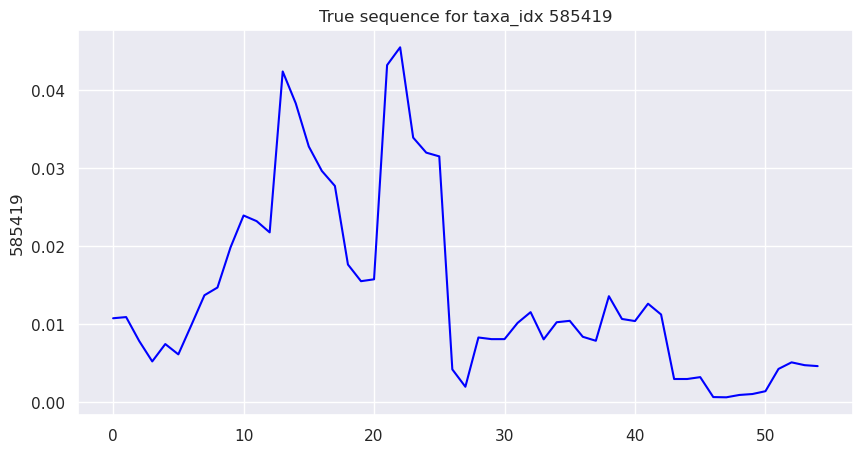

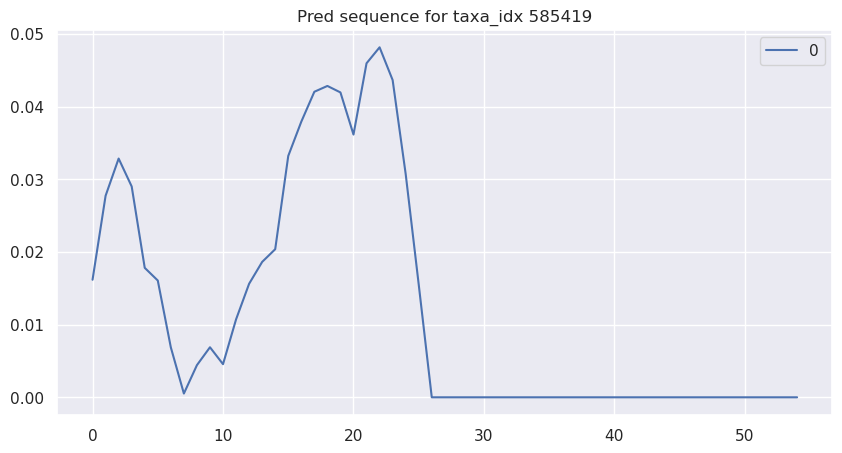

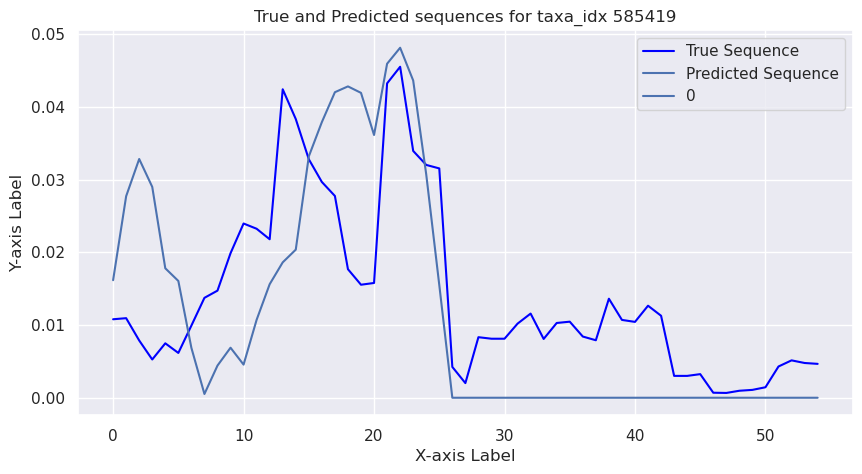

In [102]:
y_pred = model.predict(X_sequences_test)

true_sequence = y_targets_test[target_taxa].reset_index(drop=True)
pred_sequence = y_pred

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

## The Ensemble

In [22]:
class ensemble():
    
    def __init__(self, ensemble_name, overwrite_on_train=False):
        
        self.models_out_dir = f"{root_dir}/models/{ensemble_name}"
        self.overwrite_on_train = overwrite_on_train

        
    def train(self, X_sequences_train, y_targets_train, n_epochs):
        
        if not os.path.exists(self.models_out_dir):
            os.mkdir(self.models_out_dir)
        else:
            if self.overwrite_on_train is False:
                raise Exception("This model dir already exists")
            else:
                print("Overwriting an existing model dir")
                shutil.rmtree(self.models_out_dir)
                os.mkdir(self.models_out_dir)
                
        for taxa_idx in tqdm(y_targets_train.columns, desc="Training models"):
            
            model = fetch_model()
            y_targets = y_targets_train[taxa_idx]
            model.fit(x=X_sequences_train, y=y_targets, validation_split=0.05, epochs=n_epochs, verbose=0)
            
            model.save(f"{self.models_out_dir}/{taxa_idx}.model")
            
            del model
            
    
    def load(self):
        
        self.model_dic = {}
        
        for model_dir in tqdm(os.listdir(self.models_out_dir), desc="Loading the models"):
            taxa_idx = int(model_dir.replace(".model", ""))
            model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model")
            self.model_dic[taxa_idx] = model
    
         
    def predict(self, X_sequences):
        
        self.load()
        
        n_sequences = len(X_sequences)
        
        pred_list = []
        for taxa_idx in tqdm(self.model_dic.keys(), desc="Predicting values"):
            model = self.model_dic[taxa_idx]
            pred_list.append(model.predict(X_sequences, verbose=0).reshape(n_sequences,))
            del(model)
            
        pred_df = pd.DataFrame(pred_list).T
            
        return pred_df

In [23]:
# Tensorflow does not play nice with my Linux machine, thus I am filtering out its warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

model_ensemble = ensemble(ensemble_name="test_ensemble", overwrite_on_train=True)

In [24]:
model_ensemble.train(X_sequences_train=X_sequences_train, y_targets_train=y_targets_train, n_epochs=15)

Overwriting an existing model dir


Training models:   0%|          | 0/38 [00:00<?, ?it/s]


ValueError: in user code:

    File "/home/nate/anaconda3/envs/tu_medical/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_2384520/25698446.py", line 22, in mae_ignore_zeros  *
        y_true = tf.concat([y_true, tf.constant([1.0], dtype=tf.float64)], axis=0)

    ValueError: Shape must be rank 2 but is rank 1 for '{{node mae_ignore_zeros/cond/concat}} = ConcatV2[N=2, T=DT_DOUBLE, Tidx=DT_INT32](mae_ignore_zeros/cond/concat/mae_ignore_zeros/Cast, mae_ignore_zeros/cond/Const, mae_ignore_zeros/cond/concat/axis)' with input shapes: [?,1], [1], [].


In [103]:
y_test_df = pd.DataFrame(y_targets_test)
y_test_df = y_test_df.reset_index(drop=True)
y_test_df

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,351231,360015,3426658,312140,484304,301578,577170,193233,196664,583117
0,0.964313,0.010797,0.026338,0.037319,0.146555,0.155891,0.251256,0.061271,0.027507,0.105769,...,0.127669,0.038322,0.112094,0.096000,0.000756,0.146018,0.103541,0.587819,0.266264,0.265606
1,0.942749,0.010948,0.024763,0.036660,0.117093,0.117816,0.221106,0.058994,0.026746,0.083333,...,0.096320,0.032911,0.094395,0.076000,0.000728,0.119469,0.073084,0.453091,0.202535,0.222715
2,0.843602,0.007880,0.022702,0.032114,0.106266,0.187500,0.130653,0.045539,0.025137,0.105769,...,0.106315,0.029248,0.079646,0.134000,0.000700,0.084071,0.140338,0.786066,0.393724,0.255036
3,0.614218,0.005263,0.019552,0.012538,0.061959,0.130747,0.060302,0.052991,0.021132,0.096154,...,0.057701,0.017593,0.053097,0.098000,0.000616,0.044248,0.113888,0.582744,0.300905,0.142139
4,0.643839,0.007489,0.038457,0.046998,0.059506,0.115661,0.070352,0.056303,0.021900,0.083333,...,0.066333,0.075755,0.035398,0.100000,0.078095,0.070796,0.098878,0.470624,0.257333,0.089946
5,0.071848,0.006166,0.032923,0.131021,0.191766,0.112069,0.065327,0.079280,0.018082,0.083333,...,0.122672,0.066709,0.035398,0.094000,0.077647,0.070796,0.098003,0.616887,0.305854,0.089652
6,0.072038,0.009925,0.039305,0.151111,0.218657,0.112069,0.065327,0.108052,0.056499,0.083333,...,0.137210,0.078253,0.035398,0.094000,0.077871,0.070796,0.097493,0.653491,0.324321,0.100833
7,0.069100,0.013745,0.040073,0.160276,0.234555,0.020833,0.060302,0.132271,0.118418,0.048077,...,0.130395,0.081722,0.038348,0.014000,0.078599,0.070796,0.014719,0.257767,0.107423,0.037753
8,0.072275,0.014737,0.031711,0.179632,0.249746,0.005029,0.040201,0.114055,0.123040,0.019231,...,0.134030,0.085079,0.026549,0.006000,0.078739,0.053097,0.005756,0.246386,0.107906,0.070708
9,0.055782,0.019880,0.010826,0.178679,0.254228,0.002155,0.000000,0.140758,0.161656,0.000000,...,0.164925,0.092128,0.008850,0.000000,0.001709,0.004425,0.002842,0.261150,0.126735,0.127246


In [108]:
y_pred_df = model_ensemble.predict(X_sequences_test)
y_pred_df = y_pred_df.reset_index(drop=True)
y_pred_df.columns = y_test_df.columns

Predicting values: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


In [109]:
y_pred_df

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,351231,360015,3426658,312140,484304,301578,577170,193233,196664,583117
0,0.000000,0.000000,0.000000,0.052432,0.000000,0.176670,0.157199,0.038608,0.059631,0.175389,...,0.107088,0.048852,0.207322,0.207137,0.000000,0.304302,0.165328,0.000000,0.304574,0.000000
1,0.000000,0.000000,0.000000,0.057959,0.000000,0.174572,0.145004,0.040632,0.049551,0.166222,...,0.096329,0.062216,0.205374,0.219368,0.000000,0.300135,0.143268,0.000000,0.308903,0.000000
2,0.000000,0.000000,0.000000,0.062957,0.000000,0.155798,0.125013,0.041101,0.036667,0.145041,...,0.080674,0.082663,0.185614,0.219160,0.000000,0.271759,0.114821,0.000000,0.286057,0.000000
3,0.000000,0.000000,0.000000,0.063327,0.000000,0.154102,0.111955,0.040627,0.024270,0.151645,...,0.069393,0.092186,0.176781,0.226238,0.000000,0.266472,0.125790,0.000000,0.316518,0.000000
4,0.000000,0.000000,0.000000,0.060212,0.000000,0.131722,0.092435,0.037638,0.019591,0.136395,...,0.056972,0.105585,0.148130,0.211441,0.000000,0.230717,0.117096,0.000000,0.308686,0.000000
5,0.000000,0.000000,0.000000,0.061995,0.000000,0.117696,0.091388,0.036254,0.018033,0.126647,...,0.049563,0.131901,0.140227,0.203738,0.000000,0.216799,0.103386,0.000000,0.279738,0.000000
6,0.000000,0.000000,0.000000,0.057406,0.000000,0.121642,0.103802,0.033437,0.020458,0.127219,...,0.057033,0.141471,0.134229,0.195682,0.000000,0.217964,0.110006,0.000000,0.269320,0.000000
7,0.000000,0.000000,0.000000,0.055260,0.000000,0.131345,0.116584,0.030957,0.031000,0.131274,...,0.069026,0.147651,0.135477,0.187617,0.000000,0.227603,0.115100,0.000000,0.263097,0.000000
8,0.000000,0.000000,0.000000,0.056827,0.000000,0.120798,0.113987,0.029261,0.053604,0.106908,...,0.083664,0.162753,0.120387,0.164973,0.000000,0.205466,0.085327,0.000000,0.200005,0.000000
9,0.000000,0.000000,0.000000,0.059543,0.000000,0.111347,0.106532,0.028834,0.074924,0.090899,...,0.103024,0.171787,0.105607,0.144554,0.000000,0.184508,0.067929,0.000000,0.160146,0.000000


In [110]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 15, 39.473684210526315% of all taxa


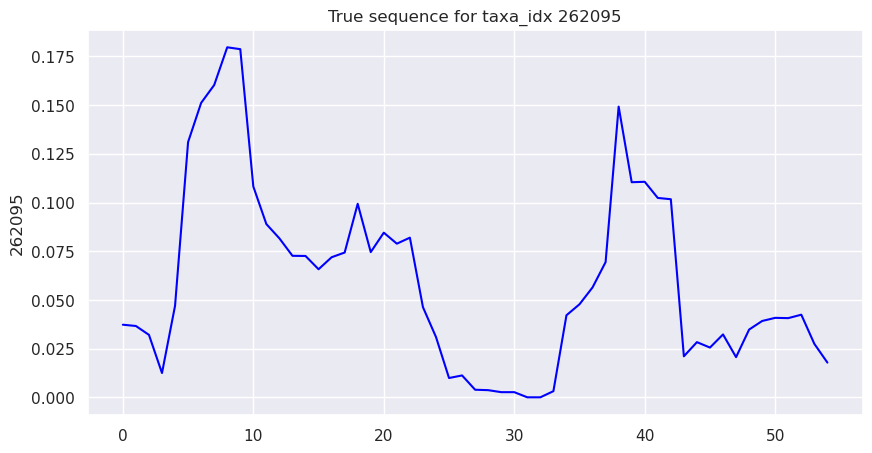

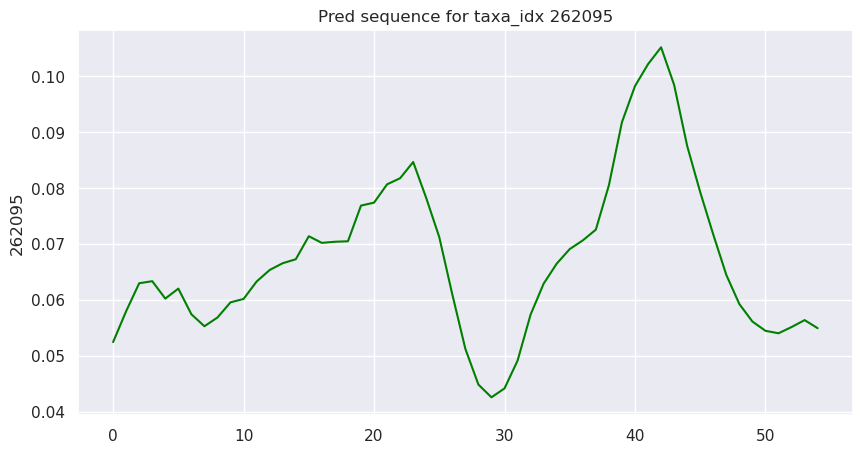

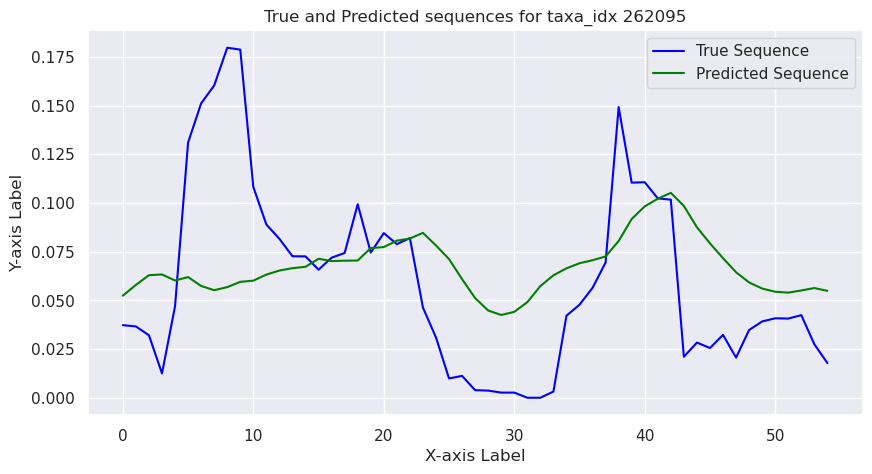

In [112]:
target_taxa = 262095

true_sequence = y_test_df[target_taxa].reset_index(drop=True)
pred_sequence = y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

In [113]:
def calculate_percentage_errors(y_pred_df, y_test_df):
    # Description: calculate percentage errors on on all taxa

    y_pred_df = y_pred_df.reset_index(drop=True)
    y_test_df = y_test_df.reset_index(drop=True)

    errors_df = []
    for col in y_pred_df.columns:
        errors = abs((y_pred_df[col] - y_test_df[col]) / (y_pred_df[col] + 1e-10))
        errors_df.append(errors)

    errors_df = pd.concat(errors_df, axis=1)

    return errors_df

In [114]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,351231,360015,3426658,312140,484304,301578,577170,193233,196664,583117
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,1986703980.368237,140313172.275396,167356454.679674,0.560627,1121406770.346462,0.399143,0.475282,1.711338,0.696511,0.363506,...,0.651414,1.886936,0.445328,0.477762,539612928.878919,0.460097,0.590571,2251894491.899253,0.470918,1719474382.497677
std,2279617298.187928,119414330.629106,114846522.069522,0.508107,874294135.347070,0.351571,0.437599,3.210262,0.482857,0.270223,...,0.378087,5.010102,0.321883,0.265220,832278163.024161,0.363799,0.324170,2188510203.863614,0.405970,1561095784.211890
min,50710899.796871,6616740.264750,0.000000,0.001772,314512.383657,0.005438,0.006018,0.013963,0.002742,0.005727,...,0.000096,0.069492,0.009499,0.047645,560224.082156,0.005341,0.052064,0.000000,0.011485,226336.514112
25%,677251175.791850,52031639.354628,76550190.858374,0.201916,607323412.842606,0.129688,0.225516,0.268216,0.310268,0.181100,...,0.463598,0.371045,0.189321,0.264780,4061624.595631,0.118525,0.283218,776684086.831017,0.150166,815603628.601719
50%,1032227474.369944,104364039.630381,132498483.385470,0.412004,968147744.993656,0.240688,0.349549,0.496868,0.792065,0.342003,...,0.602010,0.718068,0.381541,0.470354,61624649.037167,0.397588,0.585121,1268840339.872452,0.357272,1450590718.942255
75%,2873222710.453529,187825195.242573,267016760.724986,0.834170,1475220335.545438,0.647401,0.601445,1.187458,0.935647,0.437898,...,0.887308,0.915240,0.680124,0.590563,783473378.895251,0.682069,0.884495,3638880295.925118,0.765433,2064981186.498622
max,9643127833.335743,455352034.583275,400727120.482884,2.161039,3704798623.293357,1.173547,2.507408,15.472138,2.819953,1.000000,...,1.592282,26.378415,1.386536,1.000000,3214005559.329320,1.598177,1.215382,7860658154.046189,1.907143,7504187125.375329


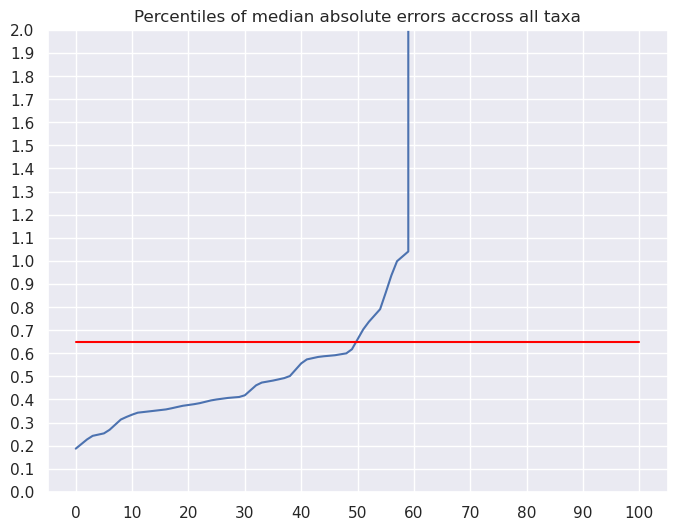

In [115]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=2, x_percentile=0.65)

In [116]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,262095,560336,182854,581079,559527,513445,589071,1078587,323231,193591,...,628226,589277,2415144,351231,360015,3426658,312140,301578,577170,196664
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.560627,0.399143,0.475282,1.711338,0.696511,0.363506,0.903673,0.657072,0.430095,0.288565,...,0.336097,0.368784,0.475067,0.651414,1.886936,0.445328,0.477762,0.460097,0.590571,0.470918
std,0.508107,0.351571,0.437599,3.210262,0.482857,0.270223,0.542066,0.386031,0.288105,0.300601,...,0.289025,0.270427,0.314562,0.378087,5.010102,0.321883,0.265220,0.363799,0.324170,0.405970
min,0.001772,0.005438,0.006018,0.013963,0.002742,0.005727,0.004164,0.041829,0.023826,0.001286,...,0.001021,0.017351,0.005145,0.000096,0.069492,0.009499,0.047645,0.005341,0.052064,0.011485
25%,0.201916,0.129688,0.225516,0.268216,0.310268,0.181100,0.658419,0.390252,0.162742,0.080346,...,0.102887,0.196093,0.259821,0.463598,0.371045,0.189321,0.264780,0.118525,0.283218,0.150166
50%,0.412004,0.240688,0.349549,0.496868,0.792065,0.342003,0.993121,0.570694,0.372132,0.186770,...,0.255113,0.315295,0.406476,0.602010,0.718068,0.381541,0.470354,0.397588,0.585121,0.357272
75%,0.834170,0.647401,0.601445,1.187458,0.935647,0.437898,0.998291,0.933641,0.641521,0.337881,...,0.522489,0.508746,0.722249,0.887308,0.915240,0.680124,0.590563,0.682069,0.884495,0.765433
max,2.161039,1.173547,2.507408,15.472138,2.819953,1.000000,2.872240,1.801418,1.000000,1.250048,...,1.219753,0.998813,1.206293,1.592282,26.378415,1.386536,1.000000,1.598177,1.215382,1.907143


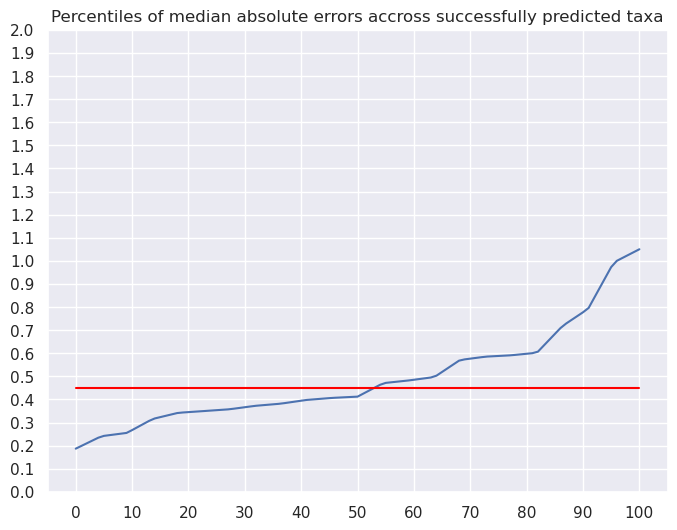

In [117]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=2, x_percentile=0.45)